# HackerEarth Machine Learning Challenge - Adopt a Pet Buddy 

## Problem Statement

A leading pet adoption agency is planning to create a virtual tour experience for 
their customers showcasing all animals that are available in their shelter. 
To enable this tour experience, you are required to build a Machine Learning model that 
determines type and breed of the animal based on its physical attributes and other factors.

## Importing Modules

In [1590]:
import warnings
warnings.filterwarnings('ignore')

In [1591]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from imblearn.over_sampling import SMOTE,SMOTENC,SVMSMOTE
from imblearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,make_scorer
from sklearn.metrics import precision_score, recall_score, confusion_matrix,classification_report
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from datetime import date
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

## Loading Data

In [1592]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


## Data Overview

In [1593]:
profile = ProfileReport(df_train,title='Detailed Customer Report',explorative=True)
profile.to_widgets()

## Evaluation

In [1594]:
def evaluate():
    # f1 score
    s1 = f1_score(y_test,y_pred_breed,average='weighted')
    s2 = f1_score(y_test,y_pred_pet,average='weighted')
    score = 100*((s1+s2)/2)
    return score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

def generate_model_report(y_actual, y_predicted):
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted,average='weighted'))
    print("Recall = " ,recall_score(y_actual, y_predicted,average='weighted'))
    print("F1 Score = " ,f1_score(y_actual, y_predicted,average='weighted'))
    pass

def generate_auc_roc_curve(y_test, y_score,n_classes):
   # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    for i in range(n_classes):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
    pass

## EDA

In [1595]:
# 1) To clean the data and see which are the redundant or unnecessary cols
def del_col(col,data):
    clean_data = data.drop(col, axis=1)
    return clean_data

# 2) Dropping the duplicates from the dataset.
def del_duplicates(data):
    clean_data = data.drop_duplicates(keep='first')
    return clean_data

# 3) Imputing missing data
def impute_col(data,filler):
    data.fillna(filler,inplace=True)
    return data

# 4) Typecasting Variables
def typecast_col(col,data,types):
    clean_data = data.col.astype(types)
    return clean_data
  
# 5) To Replace the spaces between the strings with '_' and also converting all strings to LowerCase
def convert_case(col,data,chars):
    data = data.str.replace(' ',chars) 
    data = data.str.lower() 
    return data

# 6) Encoding using Label Encoder or OHE which converts categorical features to numerical features
def label_encoder(data):
    le = LabelEncoder()
    data = le.fit_transform(data)
    return data


In [1674]:
# Removing Unnecessary Columns
X = del_col('pet_id',df_train)

# Generating new feature 
X[['issue_date','listing_date']] = X[['issue_date','listing_date']].apply(pd.to_datetime) #if conversion required
X['diff_days'] = (X['listing_date'] - X['issue_date']).dt.days
X = del_col('issue_date',X)
X = del_col('listing_date',X)

# Imputing missing values with new category 
X['condition'] = impute_col(X['condition'],3.0)
X['condition'] = X['condition'].astype('int')

# Standardization - converting cm to mts
# X['height(cm)'] = X['height(cm)']*0.01
X['length(cm)'] = X['length(m)'].apply(lambda x: x*100)
X = del_col('length(m)',X)
# replace all 0 length with mean of lengths
val = X['length(cm)'].mean()
X['length(cm)'] = X['length(cm)'].replace(to_replace=0, value=val)


## Feature Engineering

### Quantile Based Binning

In [1645]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = X['length(cm)'].quantile(quantile_list)
quantiles

0.00      1.000000
0.25     26.000000
0.50     50.263566
0.75     76.000000
1.00    100.000000
Name: length(cm), dtype: float64

In [1646]:
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
X['length_label'] = pd.qcut(X['length(cm)'],q=quantile_list, labels=quantile_labels)
X.head()

,condition,color_type,height(cm),X1,X2,breed_category,pet_category,diff_days,length(cm),length_label
0,2,Brown Tabby,7.78,13,9,0.0,1,73,80.0,75-100Q
1,1,White,14.19,13,9,0.0,2,1862,72.0,50-75Q
2,3,Brown,40.90,15,4,2.0,4,752,15.0,0-25Q
3,1,White,17.82,0,1,0.0,2,755,62.0,50-75Q
4,2,Black,11.06,18,4,0.0,1,52,50.0,25-50Q


### Custom Based Binning

In [1647]:
X['diff_days'] = abs(X['diff_days'])
X['diff_days'] =np.array(np.array(X['diff_days']) / 365.)

### One Hot Encoding

In [1648]:
# Encoding category using One Hot Encoding
X = pd.concat([X,pd.get_dummies(X['condition'], prefix='condition')],axis=1)
X = pd.concat([X,pd.get_dummies(X['X2'], prefix='X2')],axis=1)
X = pd.concat([X,pd.get_dummies(X['X1'], prefix='X1')],axis=1)
X = pd.concat([X,pd.get_dummies(X['color_type'], prefix='color_type')],axis=1)
X = pd.concat([X,pd.get_dummies(X['length_label'], prefix='length_label')],axis=1)

X = del_col('condition',X)
X = del_col('color_type',X)
X = del_col('X2',X)
X = del_col('X1',X)
X = del_col('length(cm)',X)
X = del_col('length_label',X)


In [1650]:
X['breed_category'] = X['breed_category'].astype('int')
X['pet_category'] = X['pet_category'].astype('int')
X.head()

,height(cm),breed_category,pet_category,diff_days,condition_0,condition_1,condition_2,condition_3,X2_0,X2_1,...,color_type_Tortie,color_type_Tortie Point,color_type_Tricolor,color_type_White,color_type_Yellow,color_type_Yellow Brindle,length_label_0-25Q,length_label_25-50Q,length_label_50-75Q,length_label_75-100Q
0,7.78,0,1,0.200000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,14.19,0,2,5.101370,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,40.90,2,4,2.060274,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,17.82,0,2,2.068493,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
4,11.06,0,1,0.142466,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Train Test Split

In [1651]:
Y1 = X['breed_category']
Y2 = X['pet_category']

#Splitting up for MultiLabel Classification
X1 = X.drop(['pet_category','breed_category'], axis=1)
X2 = X.drop(['pet_category','breed_category'], axis=1)

In [1652]:
X1.head()

,height(cm),diff_days,condition_0,condition_1,condition_2,condition_3,X2_0,X2_1,X2_2,X2_3,...,color_type_Tortie,color_type_Tortie Point,color_type_Tricolor,color_type_White,color_type_Yellow,color_type_Yellow Brindle,length_label_0-25Q,length_label_25-50Q,length_label_50-75Q,length_label_75-100Q
0,7.78,0.200000,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,14.19,5.101370,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,40.90,2.060274,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,17.82,2.068493,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,11.06,0.142466,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [1653]:
X2.head()

,height(cm),diff_days,condition_0,condition_1,condition_2,condition_3,X2_0,X2_1,X2_2,X2_3,...,color_type_Tortie,color_type_Tortie Point,color_type_Tricolor,color_type_White,color_type_Yellow,color_type_Yellow Brindle,length_label_0-25Q,length_label_25-50Q,length_label_50-75Q,length_label_75-100Q
0,7.78,0.200000,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,14.19,5.101370,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,40.90,2.060274,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,17.82,2.068493,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,11.06,0.142466,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## SMOTE Analysis for highly imbalaced class Balancing

In [1654]:
smote = SMOTE('auto',random_state=42)
X_train1_smote,y_train1_smote = smote.fit_resample(X1,Y1)

In [1655]:
smote1 = SMOTE('auto',random_state=42)
X_train2_smote,y_train2_smote = smote1.fit_resample(X2,Y2)

In [1656]:
from collections import Counter
print("Before SMOTE :", Counter(Y1))
print("Before SMOTE :", Counter(y_train1_smote))

Before SMOTE : Counter({0: 9000, 1: 8357, 2: 1477})
Before SMOTE : Counter({0: 9000, 2: 9000, 1: 9000})


In [1657]:
from collections import Counter
print("Before SMOTE :", Counter(Y2))
print("Before SMOTE :", Counter(y_train2_smote))

Before SMOTE : Counter({2: 10621, 1: 7184, 4: 941, 0: 88})
Before SMOTE : Counter({1: 10621, 2: 10621, 4: 10621, 0: 10621})


## Model

### CatBoost Classifier used with different set of parameters separately 

### Model to predict Breed category

In [1658]:
from catboost import CatBoostClassifier
categorical_features_indices=[0]
rf1_2 = CatBoostClassifier(learning_rate=0.055, 
                          n_estimators=1000, 
                          subsample=0.075, 
                          max_depth=3, 
                          verbose=100,
                          l2_leaf_reg = 7,
                          bootstrap_type="Bernoulli",
                          class_weights=[1, 1, 1],
                          loss_function='MultiClass')
#                           eval_metric='F1')

kf = StratifiedKFold(n_splits=7,shuffle=True,random_state=99)
f1 = []

for fold,(t_id,v_id) in enumerate(kf.split(X_train1_smote,y_train1_smote)):
    tx = X_train1_smote.iloc[t_id]; ty = y_train1_smote.iloc[t_id]
    vx = X_train1_smote.iloc[v_id]; vy = y_train1_smote.iloc[v_id]
    rf1_2.fit(tx,
              ty,
#               cat_features = categorical_features_indices
          )
           
    val_y = rf1_2.predict(vx)
    F1_score = f1_score(vy, val_y,average='weighted')
    f1.append(F1_score)
    print(f"fold {fold} f1 {F1_score}")
    print(confusion_matrix(val_y, vy))

print(f"Mean f1 score {np.mean(f1)}")

0:	learn: 1.0052118	total: 7.72ms	remaining: 7.71s
100:	learn: 0.1290996	total: 771ms	remaining: 6.87s
200:	learn: 0.1173195	total: 1.67s	remaining: 6.65s
300:	learn: 0.1151242	total: 2.35s	remaining: 5.47s
400:	learn: 0.1141922	total: 2.98s	remaining: 4.45s
500:	learn: 0.1130310	total: 3.6s	remaining: 3.58s
600:	learn: 0.1120369	total: 4.21s	remaining: 2.79s
700:	learn: 0.1114967	total: 4.83s	remaining: 2.06s
800:	learn: 0.1110384	total: 5.47s	remaining: 1.36s
900:	learn: 0.1106872	total: 6.09s	remaining: 669ms
999:	learn: 0.1102725	total: 6.71s	remaining: 0us
fold 0 f1 0.9281846282965027
[[1167  158    0]
 [ 119 1128    0]
 [   0    0 1286]]
0:	learn: 1.0056277	total: 6.59ms	remaining: 6.59s
100:	learn: 0.1272219	total: 628ms	remaining: 5.59s
200:	learn: 0.1184157	total: 1.25s	remaining: 4.97s
300:	learn: 0.1158300	total: 1.86s	remaining: 4.31s
400:	learn: 0.1147107	total: 2.48s	remaining: 3.71s
500:	learn: 0.1137572	total: 3.1s	remaining: 3.09s
600:	learn: 0.1131962	total: 3.72s	rem

### Model to predict Pet category

In [1659]:
categorical_features_indices=[0]
from catboost import CatBoostClassifier
rf2_2 = CatBoostClassifier(learning_rate=0.035, 
                          n_estimators=1000, 
                          subsample=0.075, 
                          max_depth=4,
                          l2_leaf_reg = 40,
                          verbose=100,
                          bootstrap_type="Bernoulli",
                          class_weights=[1, 1, 1, 1],
                          loss_function='MultiClass')

kf = StratifiedKFold(n_splits=7,shuffle=True,random_state=99)
f1 = []

for fold,(t_id,v_id) in enumerate(kf.split(X_train2_smote,y_train2_smote)):
    tx = X_train2_smote.iloc[t_id]; ty = y_train2_smote.iloc[t_id]
    vx = X_train2_smote.iloc[v_id]; vy = y_train2_smote.iloc[v_id]
    rf2_2.fit(tx,ty,
#     cat_features = categorical_features_indices,
          )
           
    val_y = rf2_2.predict(vx)
    F1_score = f1_score(vy, val_y,average='weighted')
    f1.append(F1_score)
    print(f"fold {fold} f1 {F1_score}")
    print(confusion_matrix(val_y, vy))

print(f"Mean f1 score {np.mean(f1)}")

0:	learn: 1.3517286	total: 13.4ms	remaining: 13.4s
100:	learn: 0.6032447	total: 1.37s	remaining: 12.2s
200:	learn: 0.4918655	total: 2.69s	remaining: 10.7s
300:	learn: 0.4353542	total: 3.93s	remaining: 9.12s
400:	learn: 0.3999216	total: 5.15s	remaining: 7.69s
500:	learn: 0.3738688	total: 6.38s	remaining: 6.36s
600:	learn: 0.3516089	total: 7.63s	remaining: 5.07s
700:	learn: 0.3346503	total: 8.88s	remaining: 3.79s
800:	learn: 0.3216373	total: 10.1s	remaining: 2.51s
900:	learn: 0.3087230	total: 11.2s	remaining: 1.24s
999:	learn: 0.2980919	total: 12.4s	remaining: 0us
fold 0 f1 0.9058339402791528
[[1485   21   11  139]
 [  11 1298   84   41]
 [   2  178 1414   33]
 [  20   21    8 1304]]
0:	learn: 1.3533088	total: 12.7ms	remaining: 12.7s
100:	learn: 0.6003055	total: 1.14s	remaining: 10.2s
200:	learn: 0.4879639	total: 2.28s	remaining: 9.05s
300:	learn: 0.4323917	total: 3.7s	remaining: 8.6s
400:	learn: 0.3987107	total: 4.87s	remaining: 7.28s
500:	learn: 0.3724793	total: 6.04s	remaining: 6.01s


## Model Interpretation and Comparative analysis of Model Feature importances

In [1677]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

def feature_imp(X_train,X_test,feature_names,model):
    
    # leveraging skater for feature importances
    interpreter = Interpretation(X_test, feature_names=feature_names)
    im_model = InMemoryModel(model.predict_proba, examples=X_train, target_names=model.classes_)
    
    # retrieving feature importances from the scikit-learn estimator
    feature_importances = model.feature_importances_
    feature_names, feature_scores = zip(*sorted(zip(feature_names, feature_importances), 
                                                          key=lambda x: x[1]))
    # plot the feature importance plots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 96))
    t = f.suptitle('Feature Importances for Random Forest', fontsize=32)
    f.subplots_adjust(top=0.85, wspace=0.6)
    y_position = list(range(len(feature_names)))
    ax1.barh(y_position, feature_scores, height=0.6, align='center', tick_label=feature_names)
    ax1.set_title("Scikit-Learn")
    ax1.set_xlabel('Relative Importance Score')
    ax1.set_ylabel('Feature')
    plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=False, ax=ax2)
    ax2.set_title("Skater")
    ax2.set_xlabel('Relative Importance Score')
    ax2.set_ylabel('Feature')
    pass 

[96/96] features ████████████████████ Time elapsed: 7 seconds

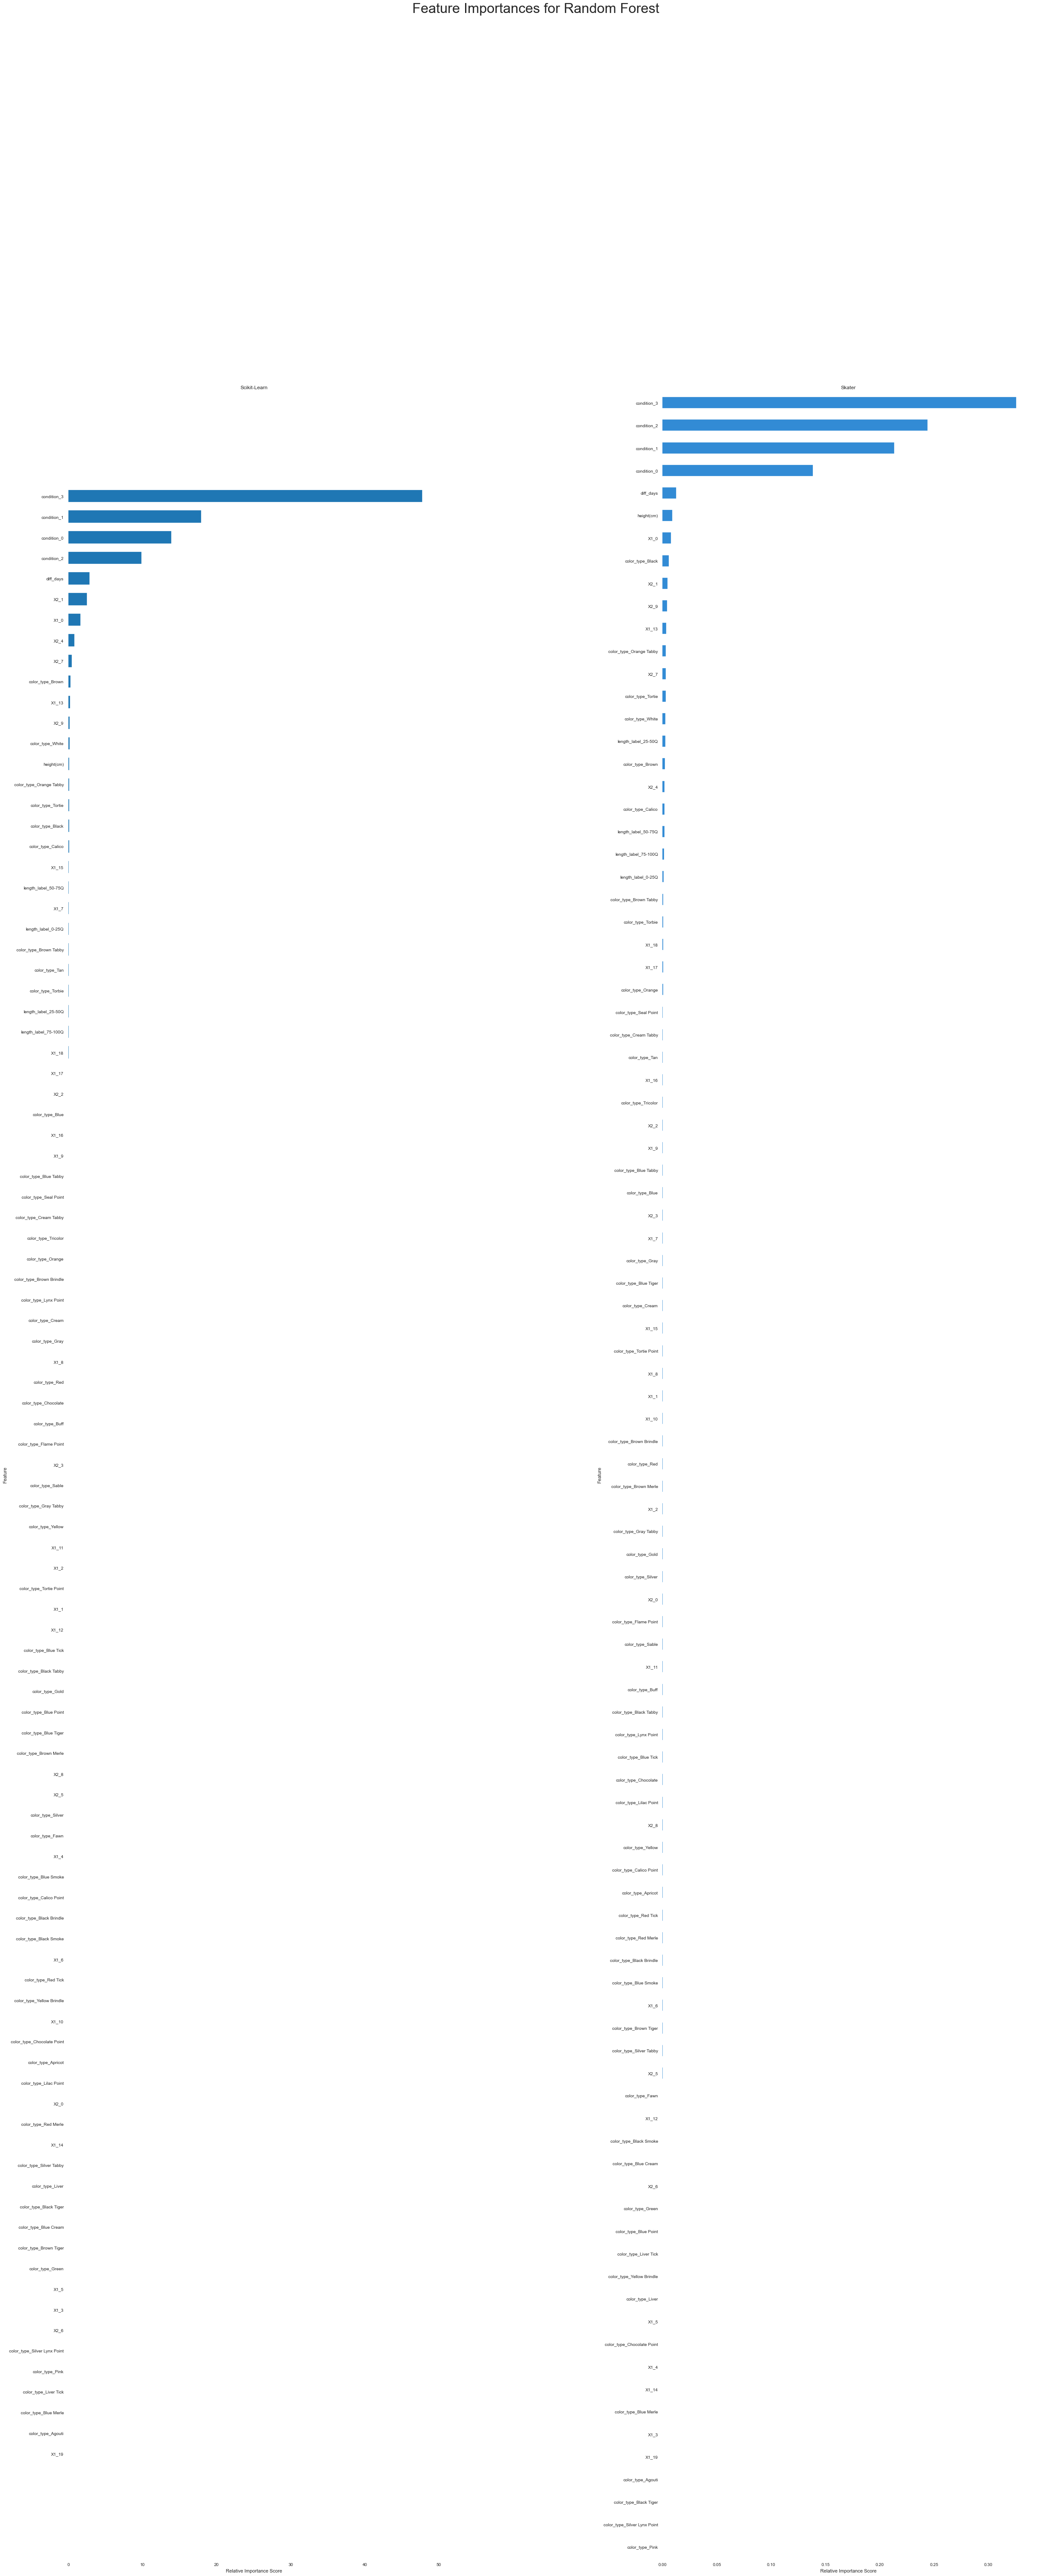

In [1678]:
feature_names = X1.columns
X1_Feature_imp = feature_imp(tx,vx,feature_names,rf1_2)
X1_Feature_imp

[7/7] features ████████████████████ Time elapsed: 1 seconds

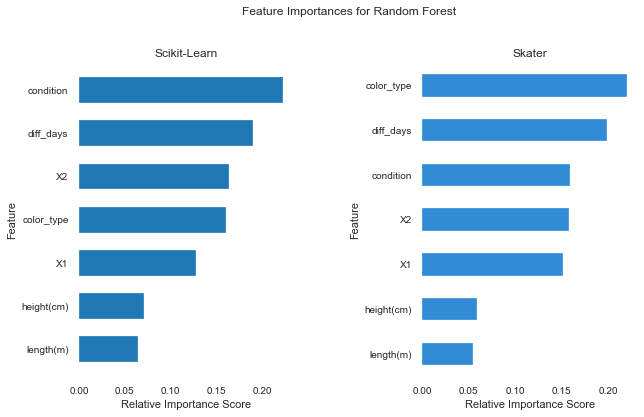

In [312]:
feature_names = X2.columns
X2_Feature_imp = feature_imp(tx1,vx1,feature_names,rf2_2)
X2_Feature_imp

## Prediction on Test Data

In [1679]:
df_test.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2
0,ANSL_75005,2005-08-17 00:00:00,2017-09-07 15:35:00,0.0,Black,0.87,42.73,0,7
1,ANSL_76663,2018-11-15 00:00:00,2019-05-08 17:24:00,1.0,Orange Tabby,0.06,6.71,0,1
2,ANSL_58259,2012-10-11 00:00:00,2018-04-02 16:51:00,1.0,Black,0.24,41.21,0,7
3,ANSL_67171,2015-02-13 00:00:00,2018-04-06 07:25:00,1.0,Black,0.29,8.46,7,1
4,ANSL_72871,2017-01-18 00:00:00,2018-04-26 13:42:00,1.0,Brown,0.71,30.92,0,7


In [1680]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8072 entries, 0 to 8071
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pet_id        8072 non-null   object 
 1   issue_date    8072 non-null   object 
 2   listing_date  8072 non-null   object 
 3   condition     7453 non-null   float64
 4   color_type    8072 non-null   object 
 5   length(m)     8072 non-null   float64
 6   height(cm)    8072 non-null   float64
 7   X1            8072 non-null   int64  
 8   X2            8072 non-null   int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 567.7+ KB


In [1681]:
test_profile = ProfileReport(df_test,title='Detailed Customer Report',explorative=True)
test_profile.to_widgets()

## EDA

In [1660]:
# Removing Unnecessary Columns
Z = del_col('pet_id',df_test)


# Imputation
Z['condition'] = impute_col(Z['condition'],3.0)
Z['condition'] = Z['condition'].astype('int')

# Standardization - converting cm to mts
Z['length(cm)'] = Z['length(m)'].apply(lambda x: x*100)
Z = del_col('length(m)',Z)
val = Z['length(cm)'].mean()
Z['length(cm)'] = Z['length(cm)'].replace(to_replace=0, value=val)

### Feature Engineering

In [1661]:
Z[['issue_date','listing_date']] = Z[['issue_date','listing_date']].apply(pd.to_datetime) #if conversion required
Z['diff_days'] = (Z['listing_date'] - Z['issue_date']).dt.days
Z = del_col('issue_date',Z)
Z = del_col('listing_date',Z)

In [1662]:
# Diff days Standardization
Z['diff_days'] = abs(Z['diff_days'])
Z['diff_days'] =np.array(np.array(Z['diff_days']) / 365.)

# Quantile Based Binning
quantile_list = [0, .25, .5, .75, 1.]
quantiles = Z['length(cm)'].quantile(quantile_list)
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
Z['length_label'] = pd.qcut(Z['length(cm)'],q=quantile_list, labels=quantile_labels)


In [1663]:
Z = pd.concat([Z,pd.get_dummies(Z['condition'], prefix='condition')],axis=1)
Z = pd.concat([Z,pd.get_dummies(Z['X2'], prefix='X2')],axis=1)
Z = pd.concat([Z,pd.get_dummies(Z['X1'], prefix='X1')],axis=1)
Z = pd.concat([Z,pd.get_dummies(Z['color_type'], prefix='color_type')],axis=1)
Z = pd.concat([Z,pd.get_dummies(Z['length_label'], prefix='length_label')],axis=1)

Z = del_col('condition',Z)
Z = del_col('color_type',Z)
Z = del_col('X2',Z)
Z = del_col('X1',Z)
Z = del_col('length(cm)',Z)
Z = del_col('length_label',Z)


In [1664]:
Z.head()

,height(cm),diff_days,condition_0,condition_1,condition_2,condition_3,X2_0,X2_1,X2_2,X2_3,...,color_type_Tortie,color_type_Tortie Point,color_type_Tricolor,color_type_White,color_type_Yellow,color_type_Yellow Brindle,length_label_0-25Q,length_label_25-50Q,length_label_50-75Q,length_label_75-100Q
0,42.73,12.065753,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,6.71,0.476712,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,41.21,5.476712,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,8.46,3.145205,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,30.92,1.268493,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [1682]:
# Adding Missing Columns from training Set
Z['color_type_Black Tiger'] = 0
Z['color_type_Brown Tiger'] = 0
Z['X1_3'] = 0
Z['X1_19'] = 0

In [1667]:
Z = Z[X1.columns]

## Prediction

In [1668]:
breed_category = rf1_2.predict(Z)
breed_category

array([[1],
       [0],
       [0],
       ...,
       [1],
       [2],
       [1]])

In [1669]:
pet_category = rf2_2.predict(Z)
pet_category

array([[2],
       [1],
       [2],
       ...,
       [2],
       [4],
       [2]])

### Submission

In [1670]:
submission = pd.DataFrame(df_test['pet_id'],columns=['pet_id',])
submission['breed_category'] = breed_category
submission['pet_category'] = pet_category
submission.head(10)

,pet_id,breed_category,pet_category
0,ANSL_75005,1,2
1,ANSL_76663,0,1
2,ANSL_58259,0,2
3,ANSL_67171,0,2
4,ANSL_72871,0,2
5,ANSL_64886,1,1
6,ANSL_73798,1,2
7,ANSL_53131,1,2
8,ANSL_66674,0,1
9,ANSL_55165,1,2


In [1671]:
submission['breed_category'].value_counts()

0    3869
1    3584
2     619
Name: breed_category, dtype: int64

In [1672]:
submission['pet_category'].value_counts()

2    4704
1    2922
4     386
0      60
Name: pet_category, dtype: int64

In [1673]:
submission.to_csv('adopt_pet_v88.csv',index=False)